In [ ]:
# Imports
# Python base libraries
import os
os.chdir("C:\\Users\\Liam\\git\\fnc-w22")

# Imported libraries
import gensim
import numpy as np
import pandas as pd
import gensim.downloader as gs_dl
os.environ["GENSIM_DATA_DIR"] = os.path.abspath('models')
gs_dl.BASE_DIR = os.environ["GENSIM_DATA_DIR"]
from gensim.models import Word2Vec, KeyedVectors
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image
from sklearn.model_selection import train_test_split

In [ ]:
def saveHyper(hypers, version):
  hyp_strs = []
  for k, v in hypers.items():
    hyp_strs.append(k+": "+str(v))
  with open(os.path.join('models', version, version+'_hyperparameters.txt'), 'w') as f:
    for k,v in hypers.items():
      f.write(k + ': ' + str(v) + '\n')

In [ ]:
# Hyperparameters
VERSION = 'cnn_glove'
OUT_FOLDER = os.path.join('models', VERSION)
try:
  os.mkdir(OUT_FOLDER)
except FileExistsError:
  pass

hypers = {}
hypers['EMBEDDING_DIM'] = 300
hypers['HEADING_LEN'] = 16 # From 90th percentile length
hypers['BODY_LEN'] = 669 # From 90th percentile length
hypers['EMBEDDING_TYPE'] = 'glove'
hypers['FILTER_NUMS'] = [64, 64, 64, 64]
hypers['N_GRAM_SIZES'] = [2, 3, 4, 5]
hypers['HEAD_POOLING_SIZES'] = [3, 3, 3, 3]
hypers['BODY_POOLING_SIZES'] = [5, 5, 5, 5]
hypers['DROPOUT_RATE'] = 0.2
hypers['DENSE_NODES'] = 32
hypers['BATCH_SIZE'] = 64
hypers['N_EPOCHS'] = 20
hypers['NOTES'] = 'Switched to glove embeddings'
saveHyper(hypers, VERSION)

In [ ]:
# Import data
def loadData(path='fnc-1', prefix='train'):
  # Get file names
  if prefix == 'train':
    body_path = 'train_bodies.csv'
    heading_path = 'train_stances.csv'
  elif prefix == 'test':
    body_path = 'competition_test_bodies.csv'
    heading_path = 'competition_test_stances.csv'
  
  # Convert to file paths
  body_path = os.path.join(path, body_path)
  heading_path = os.path.join(path, heading_path)

  # Load in data
  bodies = pd.read_csv(body_path, index_col=0)
  headings = pd.read_csv(heading_path)
  return bodies, headings

In [ ]:
train_bodies, train_headings = loadData()
print(train_bodies.head())
print(train_headings.head())

                                               articleBody
Body ID                                                   
0        A small meteorite crashed into a wooded area i...
4        Last week we hinted at what was to come as Ebo...
5        (NEWSER) – Wonder how long a Quarter Pounder w...
6        Posting photos of a gun-toting child online, I...
7        At least 25 suspected Boko Haram insurgents we...
                                            Headline  Body ID     Stance
0  Police find mass graves with at least '15 bodi...      712  unrelated
1  Hundreds of Palestinians flee floods in Gaza a...      158      agree
2  Christian Bale passes on role of Steve Jobs, a...      137  unrelated
3  HBO and Apple in Talks for $15/Month Apple TV ...     1034  unrelated
4  Spider burrowed through tourist's stomach and ...     1923   disagree


In [ ]:
test_bodies, test_headings = loadData(prefix='test')
print(test_bodies.head())
print(test_headings.head())

                                               articleBody
Body ID                                                   
1        Al-Sisi has denied Israeli reports stating tha...
2        A bereaved Afghan mother took revenge on the T...
3        CNBC is reporting Tesla has chosen Nevada as t...
12       A 4-inch version of the iPhone 6 is said to be...
19       GR editor’s Note\r\n\r\nThere are no reports i...
                                            Headline  Body ID     Stance
0  Ferguson riots: Pregnant woman loses eye after...     2008  unrelated
1  Crazy Conservatives Are Sure a Gitmo Detainee ...     1550  unrelated
2  A Russian Guy Says His Justin Bieber Ringtone ...        2  unrelated
3  Zombie Cat: Buried Kitty Believed Dead, Meows ...     1793  unrelated
4  Argentina's President Adopts Boy to End Werewo...       37  unrelated


In [ ]:
num_rows = train_headings.shape[0]
percent_unrelated = train_headings.loc[train_headings['Stance'] == 'unrelated'].shape[0] / num_rows
percent_discuss = train_headings.loc[train_headings['Stance'] == 'discuss'].shape[0] / num_rows
percent_agree = train_headings.loc[train_headings['Stance'] == 'agree'].shape[0] / num_rows
percent_disagree = train_headings.loc[train_headings['Stance'] == 'disagree'].shape[0] / num_rows
print("Number of training instances:", num_rows)
print("Unrelated:", percent_unrelated)
print('Discuss:', percent_discuss)
print('Agree:', percent_agree)
print('Disagree:', percent_disagree)

Number of training instances: 49972
Unrelated: 0.7313095333386697
Discuss: 0.1782798367085568
Agree: 0.07360121668134155
Disagree: 0.016809413271432


In [ ]:
num_rows = test_headings.shape[0]
percent_unrelated = test_headings.loc[test_headings['Stance'] == 'unrelated'].shape[0] / num_rows
percent_discuss = test_headings.loc[test_headings['Stance'] == 'discuss'].shape[0] / num_rows
percent_agree = test_headings.loc[test_headings['Stance'] == 'agree'].shape[0] / num_rows
percent_disagree = test_headings.loc[test_headings['Stance'] == 'disagree'].shape[0] / num_rows
print("Number of testing instances:", num_rows)
print("Unrelated:", percent_unrelated)
print('Discuss:', percent_discuss)
print('Agree:', percent_agree)
print('Disagree:', percent_disagree)

Number of testing instances: 25413
Unrelated: 0.7220320308503522
Discuss: 0.17565812772990202
Agree: 0.0748829339314524
Disagree: 0.027426907488293392


In [ ]:
sentences = [body for body in train_bodies['articleBody']] + [body for body in test_bodies['articleBody']] + [heading for heading in train_headings['Headline']] + [heading for heading in test_headings['Headline']]
tf_sentences = tf.data.Dataset.from_tensor_slices(sentences).batch(128)
vectorizer = TextVectorization()
vectorizer.adapt(tf_sentences)
print(vectorizer.get_vocabulary()[:4])

['', '[UNK]', 'the', 'to']


In [ ]:
from enum import Enum
from tensorflow.keras.utils import to_categorical

class Stance(Enum):
  unrelated = 0
  discuss = 1
  agree = 2
  disagree = 3

def prepData(bodies, headings):
  X_heads = headings['Headline'].values
  convertStance = lambda t: Stance[t].value
  y = to_categorical(np.vectorize(convertStance)(headings['Stance'].values), num_classes=4)
  X_bodies = bodies.loc[headings['Body ID'].values]['articleBody'].values
  return X_heads, X_bodies, y

In [ ]:
# Prepare data
X_train_head, X_train_body, y_train = prepData(train_bodies, train_headings)
X_test_head, X_test_body, y_test = prepData(test_bodies, test_headings)

In [ ]:
# Get validation set
X_train_head, X_val_head, X_train_body, X_val_body, y_train, y_val = train_test_split(X_train_head, X_train_body, y_train, random_state=42, test_size=0.1)

In [ ]:
# Find 90th percentile heading length
heading_lengths = [len(sent.split()) for sent in X_train_head]
percent_90_head = np.percentile(heading_lengths, 90)
print(percent_90_head)

16.0


In [ ]:
# Find 90th percentile body length
body_lengths = [len(sent.split()) for sent in X_train_body]
percent_90_body = np.percentile(body_lengths, 90)
print(percent_90_body)

669.0


In [ ]:
# Create word to index dictionary
vocab = vectorizer.get_vocabulary()
word_to_index = {word: i for i, word in enumerate(vocab)}

In [ ]:
# Downloads untrainable embeddings
# Common interface of returned objects is as dictionary
# Remote options are:
# "glove" for GloVe from Stanford: https://nlp.stanford.edu/projects/glove/
# "fasttext" for fastText from Facebook: https://fasttext.cc/docs/en/english-vectors.html
# "conceptnet" for ConceptNet from Open Mind Common Sense: https://conceptnet.io/
# Locally stored embeddings can be specified by providing path to embedding word vectors
def downloadEmbeddings(embedding="word2vec", model_dir=os.path.abspath('models')):
  gs_dl.BASE_DIR = model_dir
  file_names = {'glove': ('glove-wiki-gigaword-300', '.gz'), 'fasttext': ('fasttext-wiki-news-subwords-300', '.gz'), 'conceptnet': ('conceptnet-numberbatch-17-06-300', '.gz'), 'word2vec': ('word2vec', '.wv')}

  # Get embedding name and file extension
  file_name = file_names[embedding][0]
  file_ext = file_names[embedding][1]

  # First check if the embedding is stored in model_dir
  file_loc = os.path.join(model_dir, file_name, file_name+file_ext)
  if os.path.isfile(file_loc):
    if embedding == 'word2vec':
      return KeyedVectors.load(file_loc)
    else:
      return KeyedVectors.load_word2vec_format(file_loc)
  else:
    raise IOError("Could not find embeddings file: ", file_loc)

In [ ]:
# Get pretrained embeddings
wv = downloadEmbeddings(embedding=hypers['EMBEDDING_TYPE'])

In [ ]:
# Create embeddings matrix
embeddings_matrix = np.random.uniform(-0.05, 0.05, size=(len(word_to_index)+2, hypers['EMBEDDING_DIM']))

for word, i in word_to_index.items():
  try:
    embeddings_vector = wv[word]
  except KeyError:
    embeddings_vector = None
  if embeddings_vector is not None:
    embeddings_matrix[i] = embeddings_vector

# Delete word vectors
del wv

# Create CNN model


In [ ]:
from keras.models import Model
from keras.layers import Layer, Input, Dense, Concatenate, Conv1D, Reshape, Embedding
from keras.layers import MaxPool1D, Flatten, BatchNormalization, Activation, Dropout

## Heading CNN Layers

In [ ]:
input_head = Input(shape=(1,), name='head_input', dtype='string')
vec_head = TextVectorization(output_sequence_length=hypers['HEADING_LEN'], vocabulary=vectorizer.get_vocabulary(), name='vec_head')(input_head)
emb_head = Embedding(input_dim=embeddings_matrix.shape[0], 
                     output_dim=embeddings_matrix.shape[1], 
                     weights=[embeddings_matrix], 
                     trainable=False, 
                     input_length=hypers['HEADING_LEN'],
                     name='emb_head')(vec_head)
pool_heads = []
for i in range(len(hypers['N_GRAM_SIZES'])):
  conv_head = Conv1D(filters=hypers['FILTER_NUMS'][i], 
                     kernel_size=hypers['N_GRAM_SIZES'][i], 
                     padding='same', 
                     activation='relu', 
                     kernel_regularizer='l2', 
                     name='conv_head'+str(i), 
                     input_shape=emb_head.get_shape()[1:])(emb_head)
  pool_head = MaxPool1D(pool_size=hypers['HEAD_POOLING_SIZES'][i], name='pool_head'+str(i))(conv_head)
  pool_heads.append(pool_head)
concat_head = Concatenate(name='concat_head')(pool_heads)
drop_head = Dropout(hypers['DROPOUT_RATE'], name='drop_head')(concat_head)
flatten_head = Flatten(name='flatten_head')(drop_head)

## Body CNN Layers

In [ ]:
input_body = Input(shape=(1,), name='body_input', dtype='string')
vec_body = TextVectorization(output_sequence_length=hypers['BODY_LEN'], vocabulary=vectorizer.get_vocabulary(), name='vec_body')(input_body)
emb_body = Embedding(input_dim=embeddings_matrix.shape[0], 
                     output_dim=embeddings_matrix.shape[1], 
                     weights=[embeddings_matrix], 
                     trainable=False, 
                     input_length=hypers['BODY_LEN'],
                     name='emb_body')(vec_body)
pool_bodies = []
for i in range(len(hypers['N_GRAM_SIZES'])):
  conv_body = Conv1D(filters=hypers['FILTER_NUMS'][i], 
                     kernel_size=hypers['N_GRAM_SIZES'][i], 
                     padding='same',
                     activation='relu', 
                     kernel_regularizer='l2', 
                     name='conv_body'+str(i))(emb_body)
  pool_body = MaxPool1D(pool_size=hypers['BODY_POOLING_SIZES'][i], name='pool_body'+str(i))(conv_body)
  pool_bodies.append(pool_body)
concat_body = Concatenate(name='concat_body')(pool_bodies)
drop_body = Dropout(hypers['DROPOUT_RATE'], name='drop_body')(concat_body)
flatten_body = Flatten(name='flatten_body')(drop_body)

## Combined CNN Layers

In [ ]:
concat_head_body = Concatenate(name='concat_head_body')([flatten_head, flatten_body])
dense = Dense(hypers['DENSE_NODES'], activation='relu', name='dense', kernel_regularizer='l2')(concat_head_body)
bn = BatchNormalization(name='batch_norm')(dense)
drop_comb = Dropout(hypers['DROPOUT_RATE'], name='drop_comb')(bn)
output_comb = Dense(4, activation='softmax', name='output')(drop_comb)

## Model

In [ ]:
model = Model(inputs=[input_head, input_body], outputs=output_comb, name='stance_cnn')
model.summary()

Model: "stance_cnn"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 head_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 body_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 vec_head (TextVectorization)   (None, 16)           0           ['head_input[0][0]']             
                                                                                                  
 vec_body (TextVectorization)   (None, 669)          0           ['body_input[0][0]']             
                                                                                         

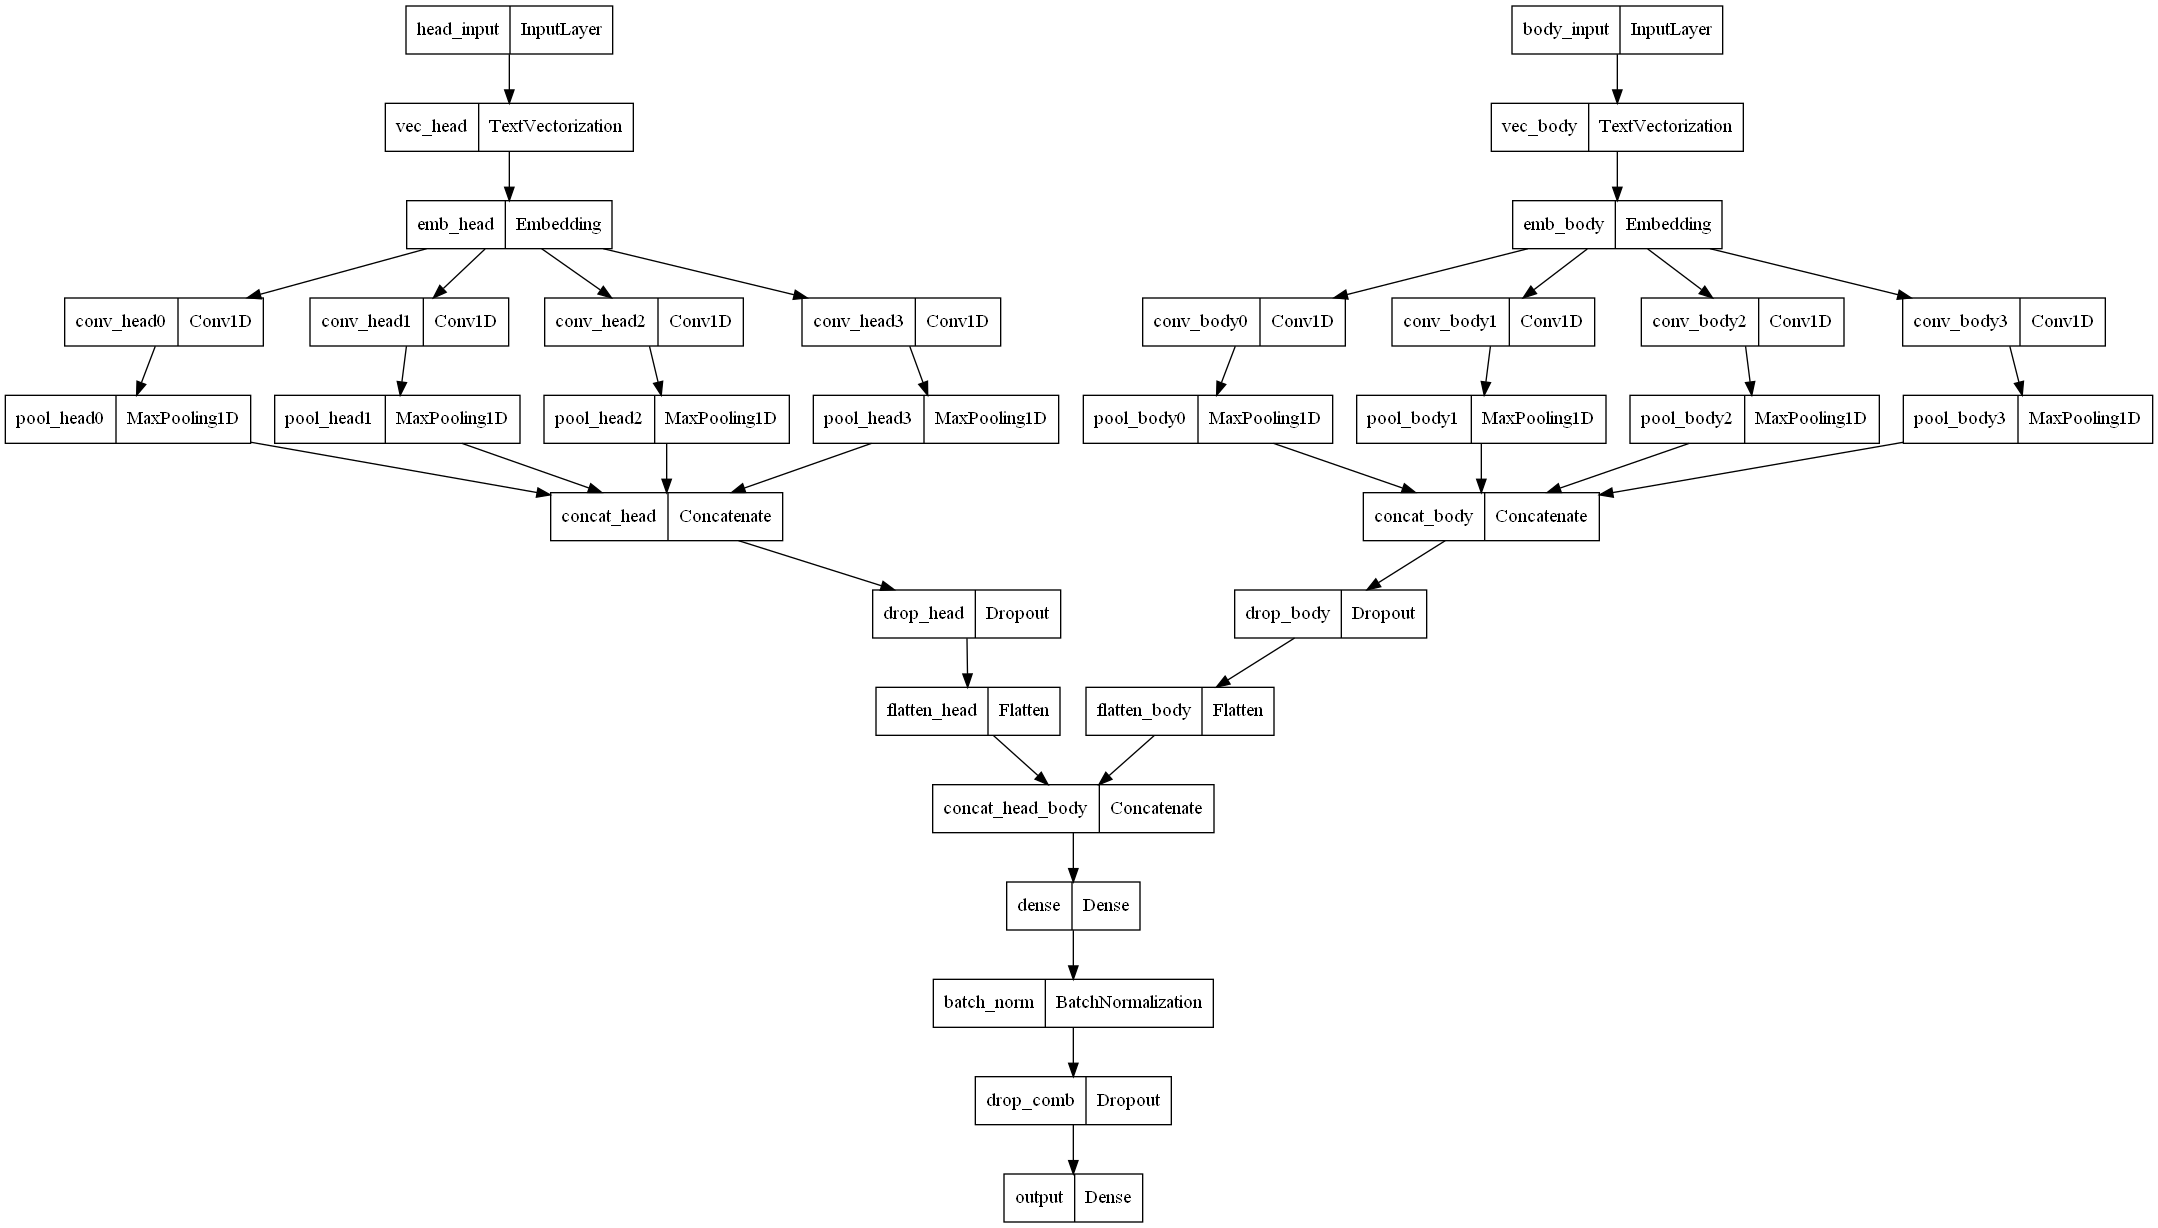

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file=os.path.join(OUT_FOLDER, VERSION+'.png'), show_layer_names=True)
Image(os.path.join(OUT_FOLDER, VERSION+'.png'))

# Training

In [ ]:
from keras.callbacks import CSVLogger

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.save(os.path.join(OUT_FOLDER, VERSION+'.h5'))

csv_logger = CSVLogger(os.path.join(OUT_FOLDER, VERSION+'_training.csv'), append=False)
history = model.fit(x = [X_train_head, X_train_body], 
                    y=y_train, 
                    batch_size=hypers['BATCH_SIZE'], 
                    epochs=hypers['N_EPOCHS'], 
                    validation_data=([X_val_head, X_val_body], y_val), 
                    callbacks=[csv_logger])

Epoch 1/20
703/703 [==============================] - 411s 582ms/step - loss: 1.5165 - accuracy: 0.7060 - val_loss: 0.8497 - val_accuracy: 0.7513
Epoch 2/20
703/703 [==============================] - 427s 608ms/step - loss: 0.8268 - accuracy: 0.7628 - val_loss: 0.7567 - val_accuracy: 0.7823
Epoch 3/20
703/703 [==============================] - 433s 615ms/step - loss: 0.7735 - accuracy: 0.7723 - val_loss: 0.7085 - val_accuracy: 0.7995
Epoch 4/20
703/703 [==============================] - 425s 604ms/step - loss: 0.7450 - accuracy: 0.7797 - val_loss: 0.6823 - val_accuracy: 0.8043
Epoch 5/20
703/703 [==============================] - 404s 575ms/step - loss: 0.7241 - accuracy: 0.7859 - val_loss: 0.6896 - val_accuracy: 0.8031
Epoch 6/20
703/703 [==============================] - 418s 594ms/step - loss: 0.7118 - accuracy: 0.7902 - val_loss: 0.6460 - val_accuracy: 0.8217
Epoch 7/20
703/703 [==============================] - 412s 586ms/step - loss: 0.6991 - accuracy: 0.7947 - val_loss: 0.6496 -

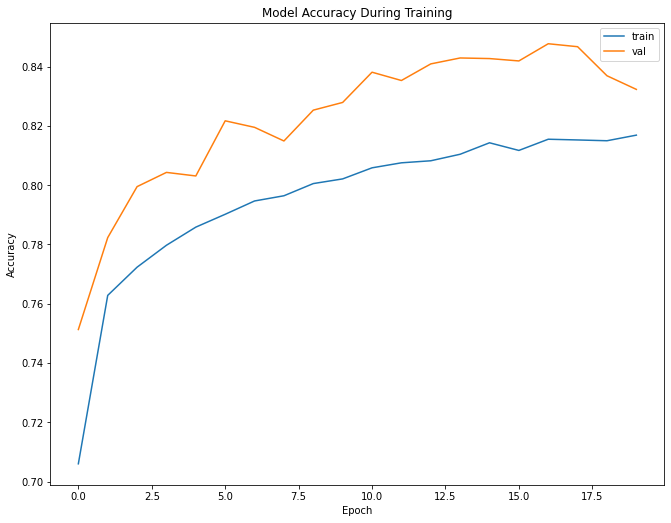

In [ ]:
plt.figure(figsize=(11,8.5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy During Training')
plt.legend(['train', 'val'])
plt.show()

In [ ]:
# Get results for test data
y_pred = model.predict([X_test_head, X_test_body])
pred_labels = []
for pred in y_pred:
  i = np.argmax(pred)
  pred_labels.append(Stance(i).name)
true_labels = []
for true in y_test:
  i = np.argmax(true)
  true_labels.append(Stance(i).name)

In [ ]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(true_labels, pred_labels)
print(acc)

0.7182150867666155


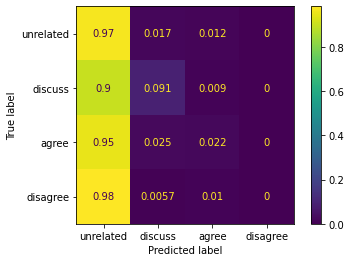

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(true_labels, pred_labels, labels=[stance.name for stance in Stance], normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[stance.name for stance in Stance])
disp.plot()
plt.show()

In [ ]:
print(pd.DataFrame(cm, index=[stance.name for stance in Stance], columns=[stance.name for stance in Stance]))

           unrelated   discuss     agree  disagree
unrelated   0.970353  0.017222  0.012426       0.0
discuss     0.900314  0.090726  0.008961       0.0
agree       0.953232  0.024698  0.022070       0.0
disagree    0.984218  0.005739  0.010043       0.0


In [ ]:
stt = str(pd.DataFrame(cm, index=[stance.name for stance in Stance], columns=[stance.name for stance in Stance]).round(4))
print(stt)

           unrelated  discuss   agree  disagree
unrelated     0.9704   0.0172  0.0124       0.0
discuss       0.9003   0.0907  0.0090       0.0
agree         0.9532   0.0247  0.0221       0.0
disagree      0.9842   0.0057  0.0100       0.0


In [ ]:
with open(os.path.join(OUT_FOLDER, VERSION+'_results.txt'), 'w') as f:
  f.write('Loss: ' + "{:.4f}".format(history.history['loss'][-1]) + '\n')
  f.write('Validation Loss: '+ "{:.4f}".format(history.history['val_loss'][-1]) + '\n')
  f.write('Accuracy: '+ "{:.4f}".format(history.history['accuracy'][-1]) + '\n')
  f.write('Validation Accuracy: ' + "{:.4f}".format(history.history['val_accuracy'][-1]) + '\n')
  f.write('Test Accuracy: ' + "{:.4f}".format(acc) + '\n')
  f.write('Test Confusion Matrix (Vertical = true, Horizontal = predicted):\n')
  f.write(str(pd.DataFrame(cm, index=[stance.name for stance in Stance], columns=[stance.name for stance in Stance]).round(4)))